### This notebook estimates the width of the Starlink satellites trails that corresponds to a fraction of the sky brightness, as a function of mirror diameter
* We assume a satellite is at 550km height, and 40 degree off zenith. The angular velocity is about 0.5 deg/sec.
* Because the satellites are at finite distances from the observatory, the FWHM of the trail is estimated as the following -

    FWHM = $\sqrt{\frac{D_{sat}^2}{d^2} + \frac{D_{pupil}^2}{d^2} + \theta_{atm}^2}$, 
    
    where $D_{sat} \sim$ 2m is the size of the satellite,
    $d$ = 550km/cos(zenith angle) is the distance from the observatory to the satellite, and
    $\theta_{atm}$ = 0.7 arcsec is the LSST seeing.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from lsst.utils import getPackageDir 
from LEOSat import getSatSIIvonK, findWidth

In [2]:
angularV = 0.5*60 # in deg/min, 0.5 deg/sec, for 40 degree zenith angle, and satellite orbit going through zenith

#### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [3]:
# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
xtalk_limit = 10e3 

#### We first determine what fraction of the flux will be in the center/brightest pixel

In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dt = 0.2/(angularV/60*3600) # in seconds

In [5]:
#satellite parameters
l1 = 2 #5 #2 #1.5 #meter
l2 = 2 #5 #2 #meter
h = 550e3  #1200e3 #

### Baseline LSST system, as defined in syseng_throughput

In [6]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [7]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
X=1.0

focalLength=10.3
pixel_size = 10 #micron
plate_scale = 0.2
e = 0.61
seeing = 0.7
zangle = 40

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']

In [22]:
def func_powerlaw(x, w0, n):
    return w0*(x/8.36)**n
def func_powerlawDeff(x, w0, n):
    return w0*(x/6.423)**n

u, 1121, 1, 2.808e-06, 23.644
g, 4032, 4, 1.760e-06, 28.139
r, 3286, 8, 3.047e-06, 22.936
i, 2498, 12, 4.800e-06, 19.373
z, 1732, 18, 8.534e-06, 15.653
y, 833, 24, 2.045e-05, 11.347
u, 1121, 1, 2.808e-05, 10.108
g, 4032, 4, 1.760e-05, 11.989
r, 3286, 8, 3.047e-05, 9.812
i, 2498, 12, 4.800e-05, 8.326
z, 1732, 18, 8.534e-05, 6.783
y, 833, 24, 2.045e-04, 5.014
u, 1121, 1, 8.425e-05, 6.814
g, 4032, 4, 5.281e-05, 8.046
r, 3286, 8, 9.142e-05, 6.620
i, 2498, 12, 1.440e-04, 5.652
z, 1732, 18, 2.560e-04, 4.651
y, 833, 24, 6.136e-04, 3.519


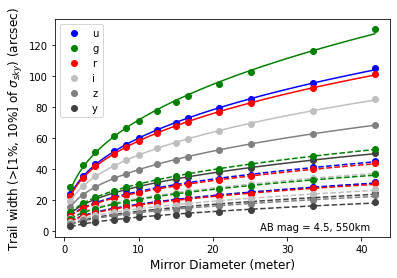

In [32]:
noiseThreshs = [0.01, 0.1, 0.3] #0.3 #0.3 means trailCount < 0.3 * sqrt(skyCount), see 7/7/20 email to ZI and TT.
mag = 4.5  # 7 # 
myfs = [0.1,0.3,0.5, 0.8, 1, 1.2, 1.5, 1.8, 2.0, 2.5, 3, 4, 5] #np.linspace(0.1,3,10) #[1,2,3] #
mydata = []
fig, ax = plt.subplots()
for ii, noiseThresh in enumerate(noiseThreshs):
    for i,f in enumerate(filterlist): # enumerate(('u','g')):  #
        widths = []
        ds = []
        for myf in myfs:
            d=8.36*myf
            ds.append(d)
            [sii, fwhm_exp] = getSatSIIvonK(focalLength,d,e, l1, l2, h, zangle, seeing, pixel_size, plate_scale)

            cs = np.sum(sii,axis=0) #cross section
            idx = np.argmax(cs==max(cs))
            pRatio = sum(cs[idx-1:idx+2])/0.21*0.2
            # print('peak pixel flux/total flux = %.4f'%pRatio)
            # PhotometricParameters object for standard m5 calculations.
            effarea=np.pi*(myf*6.423/2*100)**2
            photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                                   gain=1.0, effarea=effarea, readnoise=readnoise,
                                                   othernoise=othernoise, darkcurrent=darkcurrent)
            m5 = st.makeM5(hardware, system, darksky=None, 
                              exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                              effarea=effarea, X=1.0)

            # change exposure to dt
            photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                                   gain=1.0, effarea=effarea, readnoise=readnoise,
                                                   othernoise=othernoise, darkcurrent=darkcurrent)


            flatsource = Sed()
            flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                                  wavelen_step=system[f].wavelen_step)
            adu = flatsource.calcADU(system[f], photParams=photParams_dt)

            nSat = adu*10**(-mag/2.5)
            npeak = nSat*pRatio + m5.skyCounts[f]
            if 0: #npeak>full_well2:
                width = np.nan
            else:
                width = findWidth(cs, noiseThresh*np.sqrt(m5.skyCounts[f])/20*7/nSat)*0.07    #each pixel is 0.07"
                #width = findWidth(cs, 10/20*7/nSat)*0.07    #each pixel is 0.07"
            if myf == myfs[0]:
                print('%s, %.0f, %.0f, %.3e, %.3f'%(f, nSat, m5.skyCounts[f],noiseThresh*np.sqrt(m5.skyCounts[f])/20*7/nSat, width))
            widths.append(width)
            mydata.append(width)
            #break
        #aa = np.polyfit(ds, widths,1)
        #ww = aa[1]+aa[0]*np.array(ds)
        ds = np.array(ds)
        widths = np.array(widths)
        idx = ~np.isnan(widths)
        popt, pcov = curve_fit(func_powerlaw, ds[idx], widths[idx])
        bb = np.linspace(min(ds), max(ds),100)
        if ii==0:
            plt.plot(bb, func_powerlaw(bb, *popt), '-', color=colors[i])
        else:
            plt.plot(bb, func_powerlaw(bb, *popt), '--', color=colors[i])
        #plt.plot(ds, widths, 'o', label=r'%s: $w_0$=%.1f, $n$=%.2f'%(f,popt[0], popt[1]), color=colors[i])
        if ii==0:
            #plt.plot(ds, widths, 'o', label=r'%s: %.1f(%.2f)'%(f,popt[0], popt[1]), color=colors[i])
            plt.plot(ds, widths, 'o', label=f, color=colors[i])
        else:
            plt.plot(ds, widths, 'o', color=colors[i])
        #break
plt.legend(loc='upper left')
plt.text(0.6, 0.15, "AB mag = %.1f, %.0fkm"%(mag,h/1000), color = 'black', transform=fig.transFigure)
plt.xlabel('Mirror Diameter (meter)', fontsize=12)
#plt.ylabel(r'Trail width (>%.0f%% of $\sigma_{sky}$) (arcsec)'%(noiseThresh*100), fontsize=12)
plt.ylabel(r'Trail width (>[%.0f%%, %.0f%%] of $\sigma_{sky}$) (arcsec)'%(noiseThreshs[0]*100, noiseThreshs[1]*100), fontsize=12)
plt.savefig('width_vs_Dmirror_%.1fmag_%.0fkm.pdf'%(mag,h/1000))

In [36]:
filename = 'width_vs_Dmirror_data.txt'
np.savetxt(filename, mydata)
a = np.loadtxt(filename)

1%,u, w0 = 56 arcsec, n = 0.39 
1%,g, w0 = 67 arcsec, n = 0.40 
1%,r, w0 = 54 arcsec, n = 0.38 
1%,i, w0 = 46 arcsec, n = 0.38 
1%,z, w0 = 37 arcsec, n = 0.38 
1%,y, w0 = 27 arcsec, n = 0.39 
10%,u, w0 = 24 arcsec, n = 0.39 
10%,g, w0 = 28 arcsec, n = 0.39 
10%,r, w0 = 23 arcsec, n = 0.39 
10%,i, w0 = 20 arcsec, n = 0.40 
10%,z, w0 = 16 arcsec, n = 0.41 
10%,y, w0 = 12 arcsec, n = 0.44 


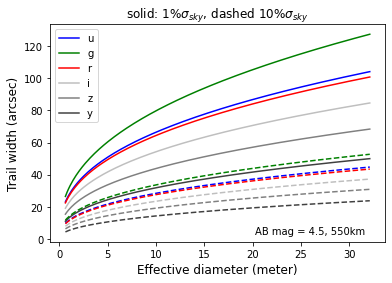

In [47]:
fig, ax = plt.subplots()
jj = 0
for ii, noiseThresh in enumerate(noiseThreshs):
    for i,f in enumerate(filterlist): # enumerate(('u','g')):  #
        widths = []
        ds = []
        for myf in myfs:
            d=6.423*myf
            ds.append(d)
            widths.append(mydata[jj])
            jj+=1
            #break
        #aa = np.polyfit(ds, widths,1)
        #ww = aa[1]+aa[0]*np.array(ds)
        ds = np.array(ds)
        widths = np.array(widths)
        idx = ~np.isnan(widths)
        popt, pcov = curve_fit(func_powerlawDeff, ds[idx], widths[idx])
        bb = np.linspace(min(ds), max(ds),200)
        if ii==0:
            plt.plot(bb, func_powerlawDeff(bb, *popt), '-', label=f, color=colors[i])
            #plt.plot(ds, widths, 'o', label=r'%s: %.1f(%.2f)'%(f,popt[0], popt[1]), color=colors[i])
            #plt.plot(ds, widths, 'o', label=f, color=colors[i])            
        elif ii==1:
            plt.plot(bb, func_powerlawDeff(bb, *popt), '--', color=colors[i])
            #plt.plot(ds, widths, 'o', color=colors[i])
        else:
            break
        print('%.0f%%,%s, w0 = %.0f arcsec, n = %.2f '%(noiseThreshs[ii]*100, f, popt[0], popt[1]))
        #plt.plot(ds, widths, 'o', label=r'%s: $w_0$=%.1f, $n$=%.2f'%(f,popt[0], popt[1]), color=colors[i])
        #break
    #break
plt.legend(loc='upper left')
plt.text(0.6, 0.15, "AB mag = %.1f, %.0fkm"%(mag,h/1000), color = 'black', transform=fig.transFigure)
plt.xlabel('Effective diameter (meter)', fontsize=12)
#plt.ylabel(r'Trail width (>%.0f%% of $\sigma_{sky}$) (arcsec)'%(noiseThresh*100), fontsize=12)
plt.ylabel(r'Trail width (arcsec)', fontsize=12)
plt.title('solid: %.0f%%$\sigma_{sky}$, dashed %.0f%%$\sigma_{sky}$'%(noiseThreshs[0]*100, noiseThreshs[1]*100))
plt.savefig('width_vs_Dmirror.pdf')

In [56]:
len(ds)

13

In [20]:
mydata[16]

66.64803757241641

In [38]:
234/13

18.0

30%,u, w0 = 16 arcsec, n = 0.41 
30%,g, w0 = 19 arcsec, n = 0.40 
30%,r, w0 = 16 arcsec, n = 0.41 
30%,i, w0 = 13 arcsec, n = 0.42 
30%,z, w0 = 11 arcsec, n = 0.45 
30%,y, w0 = 8 arcsec, n = 0.49 


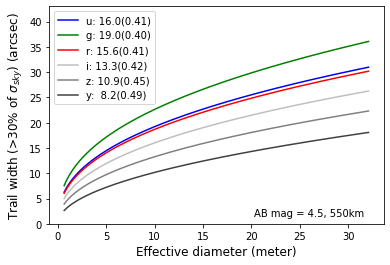

In [59]:
fig, ax = plt.subplots()
jj = 0
for ii, noiseThresh in enumerate(noiseThreshs):
    for i,f in enumerate(filterlist): # enumerate(('u','g')):  #
        widths = []
        ds = []
        for myf in myfs:
            d=6.423*myf
            ds.append(d)
            widths.append(mydata[jj])
            jj+=1
            #break
        #aa = np.polyfit(ds, widths,1)
        #ww = aa[1]+aa[0]*np.array(ds)
        ds = np.array(ds)
        widths = np.array(widths)
        idx = ~np.isnan(widths)  #np.arange(12) #
        popt, pcov = curve_fit(func_powerlawDeff, ds[idx], widths[idx])
        bb = np.linspace(min(ds), max(ds),200)
        if ii==0:
            continue
            plt.plot(bb, func_powerlawDeff(bb, *popt), '-', label=f, color=colors[i])
            #plt.plot(ds, widths, 'o', label=r'%s: %.1f(%.2f)'%(f,popt[0], popt[1]), color=colors[i])
            #plt.plot(ds, widths, 'o', label=f, color=colors[i])            
        elif ii==1:
            continue
            plt.plot(bb, func_powerlawDeff(bb, *popt), '--', color=colors[i])
            #plt.plot(ds, widths, 'o', color=colors[i])
        else:
            #plt.plot(bb, func_powerlawDeff(bb, *popt), '-', label=f, color=colors[i])
            plt.plot(bb, func_powerlawDeff(bb, *popt), '-', label=r'%s: %4.1f(%.2f)'%(f,popt[0], popt[1]), color=colors[i])
        print('%.0f%%,%s, w0 = %.0f arcsec, n = %.2f '%(noiseThreshs[ii]*100, f, popt[0], popt[1]))
        #plt.plot(ds, widths, 'o', label=r'%s: $w_0$=%.1f, $n$=%.2f'%(f,popt[0], popt[1]), color=colors[i])
        #break
    #break
plt.legend(loc='upper left')
plt.ylim([0, 43])
plt.text(0.6, 0.15, "AB mag = %.1f, %.0fkm"%(mag,h/1000), color = 'black', transform=fig.transFigure)
plt.xlabel('Effective diameter (meter)', fontsize=12)
plt.ylabel(r'Trail width (>%.0f%% of $\sigma_{sky}$) (arcsec)'%(noiseThresh*100), fontsize=12)
#plt.ylabel(r'Trail width (arcsec)', fontsize=12)
#plt.title('solid: %.0f%%$\sigma_{sky}$, dashed %.0f%%$\sigma_{sky}$'%(noiseThreshs[0]*100, noiseThreshs[1]*100))
plt.savefig('width_vs_Dmirror_%.1fmag_%.0fkm.pdf'%(mag,h/1000))